# Genetic Algorithm voor Job Sequencing (PI7)

**Doel:**  
In dit notebook wordt een genetisch algoritme (GA) geïmplementeerd voor het *job sequencing problem*.  
Het probleem bestaat uit het vinden van een optimale of bijna-optimale volgorde van taken (jobs) zodat 
de doelfunctie – bijvoorbeeld totale winst of doorlooptijd – zo goed mogelijk wordt geoptimaliseerd.  

Op basis van eerder uitgevoerd onderzoek zijn keuzes gemaakt voor:
- **Parent selection**
- **Crossover**
- **Mutatie**

Daarnaast worden combinaties van populatiegrootte, mutatiegraad en aantal iteraties geëvalueerd 
om de prestaties van het algoritme in kaart te brengen.


## Imports

Voor de implementatie van het genetisch algoritme worden de volgende libraries gebruikt

In [322]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

## Dataset inladen en voorbereiden

De dataset met jobs wordt ingeladen vanuit een CSV-bestand.  
Elke rij stelt een job voor met eigenschappen zoals winst (*profit*).  

- Als de dataset geen `id`-kolom bevat, wordt de rijindex gebruikt als unieke job-ID.  
- Daarna wordt een nieuwe kolom `job_id` toegevoegd om de jobs eenduidig te identificeren.  
- Tot slot wordt de dataset gesorteerd op aflopende winst (`profit`) en wordt de index opnieuw ingesteld.


In [323]:
df = pd.read_csv('pi-7-voorbeeld-dataset.csv')  # Importeren van dataset

# bewaar originele id (als CSV geen id-kolom heeft, gebruik rijindex)
if 'id' not in df.columns:
    df['job_id'] = df.index  # of use df.index+1 voor 1-based ids
else:
    df['job_id'] = df['id']

df = df.sort_values(by=['profit'], ascending=False).reset_index(drop=True)

## Functies voor het genetisch algoritme

Hier worden de verschillende onderdelen van het genetisch algoritme gedefinieerd:

- **`initialise_population`**: maakt de startpopulatie aan met willekeurige permutaties van jobs.  
- **`fitness`**: berekent de totale winst van een oplossing door jobs in te plannen volgens hun deadline.  
- **`evaluate`**: past de fitnessfunctie toe op de hele populatie.  
- **`parent_selection`**: selecteert twee ouders op basis van roulette wheel selectie (kans evenredig aan fitness).  
- **`order_crossover`**: voert *Order Crossover (OX)* uit, zodat nakomelingen geldige permutaties blijven.  
- **`mutate_swap`**: voert swap mutatie uit met een bepaalde kans (twee jobs wisselen van plaats).  
- **`print_schedule`**: toont het ingeplande schema van een oplossing, inclusief job-ID’s, winst en deadlines.


In [324]:
def initialise_population(n_pop, n_jobs):
    # Genereer n_pop willekeurige permutaties van n_jobs
    # Elke permutatie is één mogelijke volgorde van jobs
    return [random.sample(range(n_jobs), n_jobs) for i in range(n_pop)]

def fitness(solution, df):
    n = len(df)
    deadlines = df['deadline'].tolist()
    profits = df['profit'].tolist()
    schedule = [None] * n  # lijst om jobs in tijdslots te plaatsen

    for job in solution:
        # Plan job in het laatste vrije slot vóór de deadline
        deadline = min(deadlines[job], n)  # max n
        while deadline > 0 and schedule[deadline-1] is not None:
            deadline -= 1
        if deadline > 0:
            schedule[deadline-1] = job

    # Bereken totale winst van alle geplande jobs
    total_profit = sum(profits[j] for j in schedule if j is not None)
    return total_profit

def evaluate(population, df):
    # Bereken fitness voor elke oplossing in de populatie
    return [fitness(sol, df) for sol in population]

def parent_selection(population, fitness_scores):
    total_fitness = sum(fitness_scores)
    if total_fitness <= 0:
        # Fallback: kies twee willekeurige ouders als alle fitness <= 0
        return random.sample(population, 2)
    # Bereken selectie-kansen proportioneel aan fitness
    selection_probs = [f / total_fitness for f in fitness_scores]
    # Kies 2 ouders op basis van gewichten
    parents = random.choices(population, weights=selection_probs, k=2)
    return parents

def order_crossover(parents):
    p1, p2 = parents[0], parents[1]
    n = len(p1)
    # Kies willekeurig een segment [a, b] uit de permutatie
    a, b = sorted(random.sample(range(n), 2))
    child1 = [-1]*n
    # Kopieer het segment van ouder 1 naar kind 1
    child1[a:b+1] = p1[a:b+1]

    # Vul de resterende posities in kind 1 met jobs uit ouder 2, in volgorde
    fill = (b+1) % n
    for i in range(n):
        gene = p2[(b+1+i) % n]
        if gene not in child1:
            child1[fill] = gene
            fill = (fill+1) % n  # % n zorgt dat we weer bij 0 beginnen als we het einde bereiken

    # Herhaal hetzelfde voor kind 2, maar nu met segment uit ouder 2 en aanvullen uit ouder 1
    child2 = [-1]*n
    child2[a:b+1] = p2[a:b+1]

    fill = (b+1) % n
    for i in range(n):
        gene = p1[(b+1+i) % n]
        if gene not in child2:
            child2[fill] = gene
            fill = (fill+1) % n  # % n zorgt dat we weer bij 0 beginnen als we het einde bereiken

    return child1, child2

def mutate_swap(individual, rate):
    # Swap mutatie: verwissel twee willekeurige posities met kans 'rate'
    if random.random() < rate:
        m1, m2 = random.sample(range(len(individual)), 2)
        individual[m1], individual[m2] = individual[m2], individual[m1]
    return individual

def print_schedule(solution, df):
    n = len(df)
    deadlines = df['deadline'].tolist()
    schedule = [None] * n  # lijst van tijdslots

    for job in solution:
        # Plan job in het laatste vrije slot vóór deadline
        deadline = min(deadlines[job], n)
        while deadline > 0 and schedule[deadline-1] is not None:
            deadline -= 1
        if deadline > 0:
            schedule[deadline-1] = job

    total_profit = 0
    print("\nBeste schedule per tijdslot:")
    for slot, job in enumerate(schedule, start=1):
        if job is not None:
            profit = float(df.loc[job,'profit'])
            deadline = int(df.loc[job,'deadline'])
            job_id = int(df.loc[job,'job_id'])
            total_profit += profit
            print(f"Slot {slot}: job_id={job_id}, profit={profit}, deadline={deadline}")

    print(f"\n>>> Totale profit = {total_profit}")


## Hoofdalgoritme: `run_ga`

Deze functie voert het genetisch algoritme uit voor het job sequencing probleem.

- **Initialisatie**: maak een startpopulatie met willekeurige oplossingen.  
- **Iteraties**: herhaal voor het opgegeven aantal iteraties:
  - Bereken de fitness van de populatie.
  - Houd de beste score tot nu toe bij (*best_so_far* en *history_best*).  
  - Genereer een nieuwe populatie via:
    - ouderselectie (`parent_selection`),
    - crossover (`order_crossover`),
    - mutatie (`mutate_swap`).
  - Update de beste oplossing als er een betere wordt gevonden.  
- **Output**: geeft de beste score, het beste individu en de voortgangsgeschiedenis (*history_best*) terug.

Met de parameter `print_every` kan optioneel voortgang op het scherm worden weergegeven.


In [325]:
def run_ga(df, n_pop, mutation_rate, n_iters, print_every=20):
    n_jobs = len(df)
    # Initialiseer populatie met willekeurige oplossingen
    population = initialise_population(n_pop, n_jobs)

    best_score = -float('inf')  # beste score over alle iteraties
    best_ind = None              # beste oplossing over alle iteraties
    best_so_far = -float('inf')  # beste score tot nu toe in huidige run
    history_best = []            # lijst om voortgang bij te houden

    for it in range(1, n_iters + 1):
        # Bereken fitness van de huidige populatie
        fitness_scores = evaluate(population, df)
        best_iter = max(fitness_scores)
        if best_iter > best_so_far:
            best_so_far = best_iter
        history_best.append(best_so_far)  # sla voortgang op

        # Genereer nieuwe populatie via selectie, crossover en mutatie
        new_pop = []
        while len(new_pop) < n_pop:
            parents = parent_selection(population, fitness_scores)  # selecteer ouders
            c1, c2 = order_crossover(parents)                        # crossover
            new_pop.append(mutate_swap(c1, mutation_rate))           # mutatie kind 1
            if len(new_pop) < n_pop:
                new_pop.append(mutate_swap(c2, mutation_rate))       # mutatie kind 2

        population = new_pop
        fitness_scores = evaluate(population, df)  # update fitness na nieuwe populatie

        # Update beste oplossing over alle iteraties
        idx_best = max(range(len(population)), key=lambda i: fitness_scores[i])
        if fitness_scores[idx_best] > best_score:
            best_score = fitness_scores[idx_best]
            best_ind = population[idx_best].copy()

        # Optioneel printen van voortgang
        if print_every > 0 and (it == 1 or it % print_every == 0):
            print(f"Iter {it}/{n_iters} best score: {best_score}")

    # Return beste score, bijbehorende oplossing en historie van best scores
    return best_score, best_ind, history_best

## Parameter sweep en evaluatie

Om de invloed van verschillende parameters op de prestaties van het genetisch algoritme te onderzoeken,
wordt een grid search uitgevoerd over:

- **Populatiegroottes**: [20, 50, 100, 200]  
- **Mutatiekansen**: [0.01, 0.05, 0.1, 0.3]  
- **Aantal iteraties**: [50, 100, 200, 400]  
- **Herhalingen**: 2 runs per configuratie voor robuustere gemiddelden  

Voor elke configuratie wordt bijgehouden:
- gemiddelde score en standaardafwijking,  
- beste behaalde score,  
- gemiddelde rekentijd.  

De beste configuratie op basis van gemiddelde score wordt gerapporteerd, samen met de beste individuele run.
Daarnaast wordt het schedule van de beste run weergegeven om te controleren dat de oplossing realistisch is.


In [326]:
# pop_sizes = [20, 50, 100, 200]
# mutation_rates = [0.01, 0.05, 0.1, 0.3]
# n_iters_list = [50, 100, 200, 400]
# repeats = 10                         # herhalingen per combinatie

# records = []         # lijst om samenvatting van resultaten op te slaan
# best_overall = {'score': -float('inf')}  # beste run over alle configuraties

# for n_iters in n_iters_list:
#     for p in pop_sizes:
#         for m in mutation_rates:
#             scores = []  # scores van alle herhalingen
#             times = []   # rekentijd van alle herhalingen
#             for r in range(repeats):
#                 t0 = time.time()
#                 # Run GA met huidige parameters
#                 score, ind, history = run_ga(df, n_pop=p, mutation_rate=m, n_iters=n_iters, print_every=0)
#                 t1 = time.time()
#                 scores.append(score)
#                 times.append(t1 - t0)

#                 # Update beste oplossing als deze run beter is
#                 if score > best_overall['score']:
#                     best_overall = {
#                         'score': score,
#                         'individual': ind,
#                         'pop': p,
#                         'mut': m,
#                         'n_iters': n_iters,
#                         'history': history
#                     }

#             # Voeg samenvatting van deze parametercombinatie toe aan records
#             records.append({
#                 'pop': p,
#                 'mut': m,
#                 'n_iters': n_iters,
#                 'mean_score': np.mean(scores),
#                 'std_score': np.std(scores),
#                 'best_score': np.max(scores),
#                 'mean_time_sec': np.mean(times)
#             })

# # Zet samengevatte resultaten om in DataFrame
# res_df = pd.DataFrame(records)

# # Output van topconfiguraties
# print("\nTop 10 configuraties op mean_score:")
# print(res_df.sort_values(['mean_score'], ascending=False).head(10).to_string(index=False))

# best_row = res_df.loc[res_df['mean_score'].idxmax()]
# print("\nBeste configuratie (op basis van mean_score):")
# print(best_row.to_string())

# print("\nBeste individuele run gevonden over alle tests:")
# print(f"score={best_overall['score']}, pop={best_overall['pop']}, mut={best_overall['mut']}, n_iters={best_overall['n_iters']}")

# # Toon schedule van beste individuele run
# print("\nSchedule voor beste individuele run:")
# if best_overall.get('individual') is not None:
#     print_schedule(best_overall['individual'], df)

## Visualisatie van de voortgang

Om de werking van het genetisch algoritme inzichtelijk te maken, wordt de voortgang van de beste individuele run geplot.  
De grafiek toont de behaalde winst (*profit*) per iteratie.  
Dit maakt zichtbaar hoe de oplossing zich gedurende de iteraties verbetert.


In [327]:
# best_history = best_overall['history']

# plt.figure(figsize=(10,5))
# plt.plot(best_history, label="Beste individuele run")
# plt.xlabel("Iteratie")
# plt.ylabel("Profit")
# plt.title("GA progressie: profit van beste individuele run")
# plt.legend()
# plt.grid(True)
# plt.show()

## Uitvoering met gekozen parameters

Na het testen van verschillende configuraties wordt hier het algoritme uitgevoerd met de gekozen instellingen:  

- Populatiegrootte = 200  
- Mutatiekans = 0.05  
- Aantal iteraties = 400  

De functie `run_ga` retourneert:
- de beste behaalde score,  
- de bijbehorende oplossing (*ind*),  
- de voortgangsgeschiedenis (*history*).


In [334]:
# GA parameters
N_POP = 200
N_JOBS = len(df)
N_ITERS = 400
MUTATION_RATE = 0.05

score, ind, history = run_ga(df, n_pop=N_POP, mutation_rate=MUTATION_RATE, n_iters=N_ITERS, print_every=40)

Iter 1/400 best score: 770
Iter 40/400 best score: 804
Iter 80/400 best score: 859
Iter 120/400 best score: 859
Iter 160/400 best score: 859
Iter 200/400 best score: 859
Iter 240/400 best score: 859
Iter 280/400 best score: 859
Iter 320/400 best score: 859
Iter 360/400 best score: 859
Iter 400/400 best score: 859


## Plot voortgang van de GA

De grafiek toont de evolutie van de winst (*profit*) tijdens de iteraties van het algoritme.  
Hiermee is te zien hoe snel de oplossing verbetert en of het algoritme convergeert naar een stabiele, hoge winst.


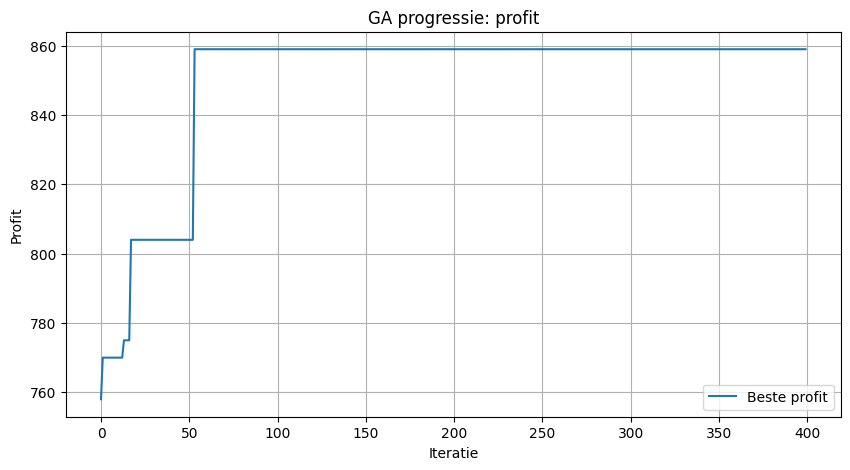

In [335]:
plt.figure(figsize=(10,5))
plt.plot(history, label="Beste profit")
plt.xlabel("Iteratie")
plt.ylabel("Profit")
plt.title("GA progressie: profit")
plt.legend()
plt.grid(True)
plt.show()

## Beste schedule tonen

Hier wordt het schema van de beste gevonden oplossing weergegeven.  
Voor elk tijdslot wordt getoond welke job gepland is, inclusief:
- job-ID  
- winst (*profit*)  
- deadline  

Daarnaast wordt de totale behaalde winst van deze oplossing weergegeven.


In [336]:
print_schedule(ind, df)


Beste schedule per tijdslot:
Slot 1: job_id=135, profit=89.0, deadline=1
Slot 2: job_id=12, profit=81.0, deadline=2
Slot 3: job_id=143, profit=96.0, deadline=7
Slot 4: job_id=106, profit=92.0, deadline=4
Slot 5: job_id=142, profit=86.0, deadline=5
Slot 6: job_id=192, profit=83.0, deadline=6
Slot 7: job_id=162, profit=97.0, deadline=8
Slot 8: job_id=72, profit=64.0, deadline=8
Slot 9: job_id=137, profit=71.0, deadline=9
Slot 10: job_id=23, profit=100.0, deadline=10

>>> Totale profit = 859.0
